
# Cancer Detection on Gigapixel Pathology Images

*Yunqiu Yao*  
*Dec. 24th, 2018*


Demo video can be accessed here https://youtu.be/V-wlT_wrP5g

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 561 µs, sys: 931 µs, total: 1.49 ms
Wall time: 6.94 ms


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from PIL import ImageOps
from skimage.color import rgb2gray
import shutil

## 1. Data preparation and visualization

We use three slide images in this project, 091 and 078 for training/validation, and 110 for testing/prediction

In [0]:
def copy_img(num_lst=[]):
  for num in num_lst:
    shutil.copyfile("drive/My Drive/slides/tumor_%s.tif"%(num),
                    "tumor_%s.tif"%(num))
    shutil.copyfile("drive/My Drive/slides/tumor_%s_mask.tif"%(num),
                    "tumor_%s_mask.tif"%(num))
  
copy_img(num_lst=["091","110","078"])

In [0]:
def preview_img(num):
  slide = open_slide('tumor_%s.tif'%(num))
  mask = open_slide('tumor_%s_mask.tif'%(num))

  print('Slide %s includes %d levels'%(num,len(slide.level_dimensions)))
  for i in range(len(slide.level_dimensions)):
    print('Level %d, dimensions: %s downsample factor %d' % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]
  
  last_lvl = len(slide.level_dimensions)-1
  mask_img = mask.read_region((0,0),last_lvl,
                              (slide.level_dimensions[last_lvl][0],
                               slide.level_dimensions[last_lvl][1]))
  mask_img = np.asarray(mask_img)[:,:,0]

  slide_img = slide.read_region((0,0),last_lvl,
                                (slide.level_dimensions[last_lvl][0],
                                 slide.level_dimensions[last_lvl][1]))
  slide_img = np.asarray(slide_img)

  plt.figure(figsize=(10,10))
  plt.imshow(slide_img)
  plt.imshow(mask_img,cmap='jet',alpha=.5)

Slide 091 includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


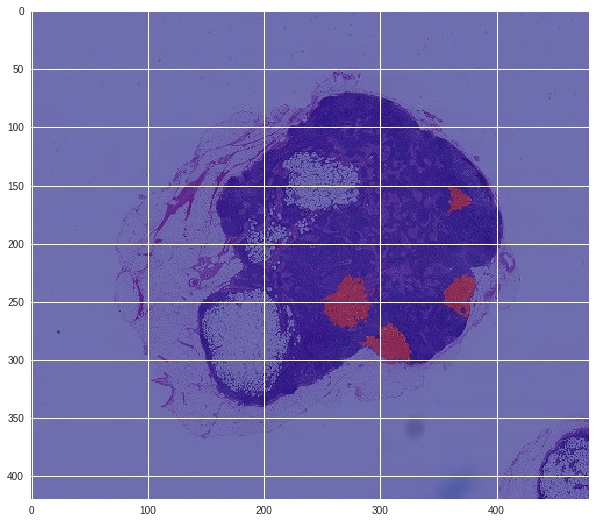

In [0]:
preview_img('091')

Slide 078 includes 9 levels
Level 0, dimensions: (94208, 111104) downsample factor 1
Level 1, dimensions: (47104, 55552) downsample factor 2
Level 2, dimensions: (23552, 27776) downsample factor 4
Level 3, dimensions: (11776, 13888) downsample factor 8
Level 4, dimensions: (5888, 6944) downsample factor 16
Level 5, dimensions: (2944, 3472) downsample factor 32
Level 6, dimensions: (1472, 1736) downsample factor 64
Level 7, dimensions: (736, 868) downsample factor 128
Level 8, dimensions: (368, 434) downsample factor 256


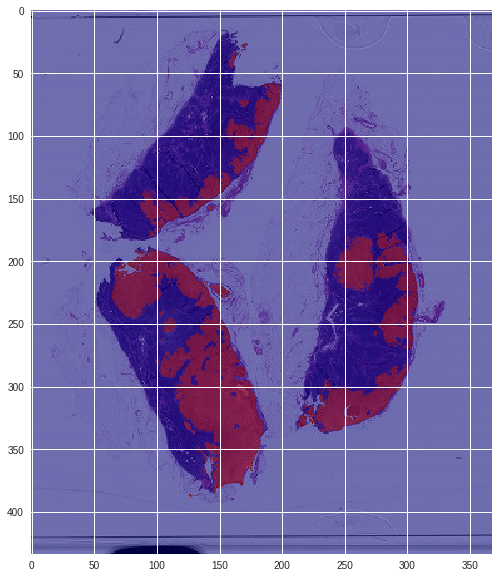

In [0]:
preview_img('078')

Slide 110 includes 9 levels
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


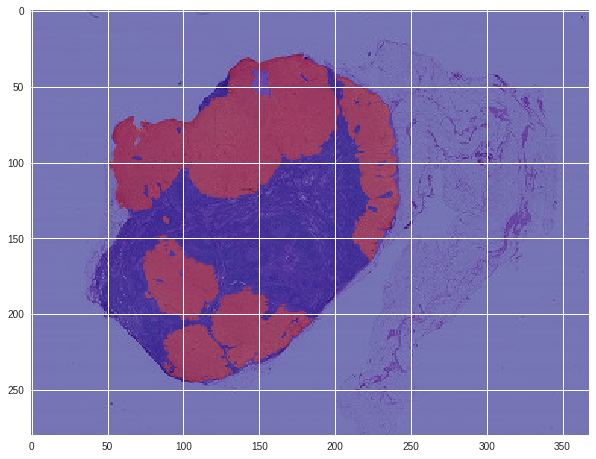

In [0]:
preview_img('110')

## 2. Data preprocessing

### (1) Create sample from 091

In [0]:
num = '091'
lvl = 0
win_w = 299
win_h = 299

slide = open_slide("tumor_{}.tif".format(num))
mask = open_slide("tumor_{}_mask.tif".format(num))
  
  
# create dir
img_dir = '%s'%num
if os.path.exists('{}/pos'.format(img_dir)):
  shutil.rmtree('{}/pos'.format(img_dir))
os.makedirs('{}/pos'.format(img_dir))

if os.path.exists('{}/neg'.format(img_dir)):
  shutil.rmtree('{}/neg'.format(img_dir))
os.makedirs('{}/neg'.format(img_dir))
  
  
# slide window to extract patches
width, height = slide.level_dimensions[lvl]
dwnsample = int(slide.level_downsamples[lvl])
nw = width//win_w
nh = height//win_h

n = 0
for h in range(nh):
  for w in range(nw):
    s_patch = slide.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
    s_patch = s_patch.convert('RGB')
    s_patch = np.asarray(s_patch)
    s_gray = rgb2gray(s_patch)
    tissue = sum(sum(s_gray<=0.8))
    if tissue >= 0.1 * win_h * win_w:
      m_patch = mask.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
      m_patch = m_patch.convert('RGB')
      m_patch = np.asarray(m_patch)[:,:,0]
      if np.any(m_patch>0):
        plt.imsave('%s/pos/%s_slide%s.jpeg'%(img_dir,num,n),s_patch)
      else:
        plt.imsave('%s/neg/%s_slide%s.jpeg'%(img_dir,num,n),s_patch)
      n+=1
  
print('n: {}, nw: {}, nh: {}'.format(n, nw, nh))
print('pos: {}, neg: {}'.format(len(os.listdir('{}/pos'.format(img_dir))),
                                len(os.listdir('{}/neg'.format(img_dir)))))

n: 13927, nw: 205, nh: 179
pos: 708, neg: 13219


In [0]:
##### check train and val set
num = '091'
img_dir = '%s'%num
print('pos: {}, neg: {}'.format(len(os.listdir('{}/pos'.format(img_dir))),
                                  len(os.listdir('{}/neg'.format(img_dir)))))

pos: 708, neg: 13219


In [0]:
%%time

### create train, val set using 091
num='091'

# create train, val, and test directories
img_dir = '%s'%num
train_dir = 'train'
val_dir = 'val'


for dir in [train_dir,val_dir]:
  if os.path.exists(dir):
    shutil.rmtree(dir)
  os.makedirs(os.path.join(dir,'pos'),exist_ok=True)
  os.makedirs(os.path.join(dir,'neg'),exist_ok=True)
  

# copy samples to train and val
fn_pos = os.listdir('%s/pos'%img_dir)
fn_neg = os.listdir('%s/neg'%img_dir)
np.random.shuffle(fn_pos)
np.random.shuffle(fn_neg)


n_train = 500
n_val = len(fn_pos)-n_train

for i, fn in enumerate(fn_pos):
  src = os.path.join('%s/pos'%img_dir,fn)
  if i < n_train:
    dst = os.path.join(train_dir,'pos',fn)
  else:
    dst = os.path.join(val_dir,'pos',fn)
  shutil.copyfile(src,dst)

for j, fn in enumerate(fn_neg):
  if j < len(fn_pos):
    src = os.path.join('%s/neg'%img_dir,fn)
    if j < n_train:
      dst = os.path.join(train_dir,'neg',fn)
    else:
      dst = os.path.join(val_dir,'neg',fn)
    shutil.copyfile(src,dst)

print('train/pos: %d'%len(os.listdir('%s/pos'%train_dir)))
print('train/neg: %d'%len(os.listdir('%s/neg'%train_dir)))
print('val/pos: %d'%len(os.listdir('%s/pos'%val_dir)))
print('val/neg: %d'%len(os.listdir('%s/neg'%val_dir)))

train/pos: 500
train/neg: 500
val/pos: 208
val/neg: 208
CPU times: user 200 ms, sys: 467 ms, total: 667 ms
Wall time: 1.09 s


### (2) Create sample from 078

In [0]:
%%time
num = '078'
lvl = 1
win_w = 299
win_h = 299

slide = open_slide("tumor_{}.tif".format(num))
mask = open_slide("tumor_{}_mask.tif".format(num))
  
  
  # create dir
img_dir = '%s'%num
if os.path.exists('{}/pos'.format(img_dir)):
  shutil.rmtree('{}/pos'.format(img_dir))
os.makedirs('{}/pos'.format(img_dir))

if os.path.exists('{}/neg'.format(img_dir)):
  shutil.rmtree('{}/neg'.format(img_dir))
os.makedirs('{}/neg'.format(img_dir))
  
  
  # slide window to extract patches
width, height = slide.level_dimensions[lvl]
dwnsample = int(slide.level_downsamples[lvl])
nw = int((width*0.5)//win_w)
nh = height//win_h

n = 0
for h in range(nh):
  for w in range(nw):
    s_patch = slide.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
    s_patch = s_patch.convert('RGB')
    s_patch = np.asarray(s_patch)
    s_gray = rgb2gray(s_patch)
    tissue = sum(sum(s_gray<=0.8))
    if tissue >= 0.1 * win_h * win_w:
      m_patch = mask.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
      m_patch = m_patch.convert('RGB')
      m_patch = np.asarray(m_patch)[:,:,0]
      if np.any(m_patch>0):
        plt.imsave('%s/pos/%s_slide%s.jpeg'%(img_dir,num,n),s_patch)
      else:
        plt.imsave('%s/neg/%s_slide%s.jpeg'%(img_dir,num,n),s_patch)
      n+=1
  
print('n: {}, nw: {}, nh: {}'.format(n, nw, nh))
print('pos: {}, neg: {}'.format(len(os.listdir('{}/pos'.format(img_dir))),
                                len(os.listdir('{}/neg'.format(img_dir)))))

n: 7023, nw: 78, nh: 185
pos: 2374, neg: 4649
CPU times: user 8min 9s, sys: 8.66 s, total: 8min 18s
Wall time: 8min 34s


In [0]:
%%time

### create train, val set using 091
num='078'
    
# create train, val, and test directories
img_dir = '%s'%num
train_dir = 'train'
val_dir = 'val'
   
# copy samples to train and val
fn_pos = os.listdir('%s/pos'%img_dir)
fn_neg = os.listdir('%s/neg'%img_dir)
np.random.shuffle(fn_pos)
np.random.shuffle(fn_neg)


n_train = 2000
n_val = len(fn_pos)-n_train

for i, fn in enumerate(fn_pos):
  src = os.path.join('%s/pos'%img_dir,fn)
  if i < n_train:
    dst = os.path.join(train_dir,'pos',fn)
  else:
    dst = os.path.join(val_dir,'pos',fn)
  shutil.copyfile(src,dst)

for j, fn in enumerate(fn_neg):
  if j < len(fn_pos):
    src = os.path.join('%s/neg'%img_dir,fn)
    if j < n_train:
      dst = os.path.join(train_dir,'neg',fn)
    else:
      dst = os.path.join(val_dir,'neg',fn)
    shutil.copyfile(src,dst)

print('train/pos: %d'%len(os.listdir('%s/pos'%train_dir)))
print('train/neg: %d'%len(os.listdir('%s/neg'%train_dir)))
print('val/pos: %d'%len(os.listdir('%s/pos'%val_dir)))
print('val/neg: %d'%len(os.listdir('%s/neg'%val_dir)))

train/pos: 2500
train/neg: 2500
val/pos: 582
val/neg: 582
CPU times: user 784 ms, sys: 2.1 s, total: 2.88 s
Wall time: 4.85 s


In [0]:
## check completeness of train and val samples

# create train, val, and test directories
train_dir = 'train'
val_dir = 'val'
n_train = len(os.listdir('%s/pos'%train_dir))
n_val = len(os.listdir('%s/pos'%val_dir))

print('train/pos: %d'%len(os.listdir('%s/pos'%train_dir)))
print('train/neg: %d'%len(os.listdir('%s/neg'%train_dir)))
print('val/pos: %d'%len(os.listdir('%s/pos'%val_dir)))
print('val/neg: %d'%len(os.listdir('%s/neg'%val_dir)))

train/pos: 2500
train/neg: 2500
val/pos: 582
val/neg: 582


## 3. Modeling

In [0]:
from keras import layers
from keras import models
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top = False,
                        input_shape = (299,299,3))

conv_base.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(dir,sample_cnt,batch_size):
  features = np.zeros(shape=(sample_cnt,8,8,2048))
  labels = np.zeros(shape=(sample_cnt))
  generator = datagen.flow_from_directory(
    dir,
    batch_size=batch_size,
    target_size=(299,299),
    class_mode='binary')
  
  i = 0
  for input_batch, label_batch in generator:
    feature_batch = conv_base.predict(input_batch)
    features[i*batch_size : (i+1)*batch_size] = feature_batch
    labels[i*batch_size : (i+1)*batch_size] = label_batch
    i += 1
    if i*batch_size >= sample_cnt:
      break
  return features, labels

In [0]:
%%time
train_features, train_labels = extract_features(train_dir,n_train*2,20)

Found 5000 images belonging to 2 classes.
CPU times: user 55min 36s, sys: 2min 5s, total: 57min 42s
Wall time: 29min 43s


In [0]:
%%time
val_features, val_labels = extract_features(val_dir,n_val*2,20)
print(train_features.shape,val_features.shape)

Found 1164 images belonging to 2 classes.
(5000, 8, 8, 2048) (1164, 8, 8, 2048)
CPU times: user 13min 22s, sys: 41.4 s, total: 14min 3s
Wall time: 7min 17s


In [0]:
train_features_rs = np.reshape(train_features, (n_train*2,8*8*2048))
val_features_rs = np.reshape(val_features,(n_val*2,8*8*2048))

In [0]:
import keras
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

filepath = "weights.pred110.{epoch:02d}.hdf5"
callback_list = [keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                 save_best_only=False)]


history = model.fit(train_features_rs,train_labels,epochs=20,
                    validation_data=(val_features_rs,val_labels),
                    callbacks=callback_list)

Train on 5000 samples, validate on 1164 samples
Epoch 1/20
5000/5000 [==============================] - 165s 33ms/step - loss: 0.3823 - acc: 0.8390 - val_loss: 0.3418 - val_acc: 0.8531
Epoch 2/20
5000/5000 [==============================] - 158s 32ms/step - loss: 0.2545 - acc: 0.8952 - val_loss: 0.3238 - val_acc: 0.8703
Epoch 3/20
5000/5000 [==============================] - 159s 32ms/step - loss: 0.2038 - acc: 0.9204 - val_loss: 0.4920 - val_acc: 0.8522
Epoch 4/20
5000/5000 [==============================] - 159s 32ms/step - loss: 0.1693 - acc: 0.9352 - val_loss: 0.3905 - val_acc: 0.8729
Epoch 5/20
5000/5000 [==============================] - 160s 32ms/step - loss: 0.1474 - acc: 0.9414 - val_loss: 0.4016 - val_acc: 0.8548
Epoch 6/20
5000/5000 [==============================] - 159s 32ms/step - loss: 0.1194 - acc: 0.9532 - val_loss: 0.4552 - val_acc: 0.8866
Epoch 7/20
5000/5000 [==============================] - 159s 32ms/step - loss: 0.1056 - acc: 0.9574 - val_loss: 0.6417 - val_acc: 

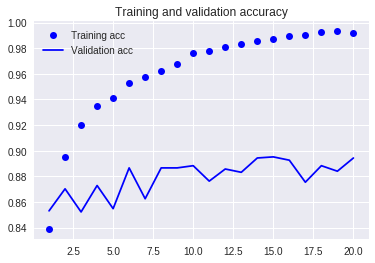

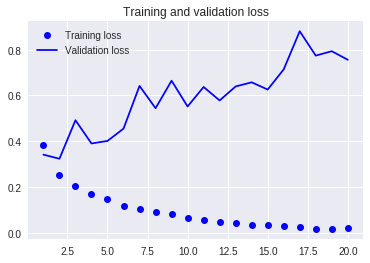

In [0]:
# plot curves of loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 4. Prediction and evaluation

In [0]:
%%time
from keras.models import load_model
model = load_model('weights.pred110.02.hdf5')

CPU times: user 7.64 s, sys: 2.44 s, total: 10.1 s
Wall time: 13.6 s


In [0]:
%%time
num = '110'
lvl = 1
win_w = 299
win_h = 299

slide = open_slide("tumor_{}.tif".format(num))
mask = open_slide("tumor_{}_mask.tif".format(num))
  
  
  # slide window to extract patches
width, height = slide.level_dimensions[lvl]
dwnsample = int(slide.level_downsamples[lvl])
nw = width//win_w
nh = height//win_h
total_n = nw*nh
print('total patches: {}, nw: {}, nh: {}'.format(total_n, nw, nh))

n = 0
test_preds = np.zeros(shape=(nw*nh))
test_imgs = np.zeros(shape=(nw*nh,299,299,3),dtype=np.uint8)
test_lbls = np.zeros(shape=(nw*nh))
for h in range(nh):
  for w in range(nw):
    s_patch = slide.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
    s_patch = s_patch.convert('RGB')
    s_patch = np.asarray(s_patch)
    test_imgs[n] = s_patch
    m_patch = mask.read_region((win_w*w*dwnsample,win_h*h*dwnsample),lvl,(win_w,win_h))
    m_patch = m_patch.convert('RGB')
    m_patch = np.asarray(m_patch)[:,:,0]
    test_lbls[n] = 1 if np.any(m_patch>0) else 0
    img = s_patch/255.
    img = np.expand_dims(img,axis=0)
    feature = conv_base.predict(img)
    feature = np.reshape(feature, (1,8*8*2048))
    pred = model.predict(feature)
    test_preds[n] = 1 if pred>0.5 else 0
    if n%1000 == 0:
      print('%d/%d completed'%(n,total_n))
    n+=1
  
print('preds shape: %s, lbl shape: %s'%(test_preds.shape,test_lbls.shape))

total patches: 18683, nw: 157, nh: 119
0/18683 completed
1000/18683 completed
2000/18683 completed
3000/18683 completed
4000/18683 completed
5000/18683 completed
6000/18683 completed
7000/18683 completed
8000/18683 completed
9000/18683 completed
10000/18683 completed
11000/18683 completed
12000/18683 completed
13000/18683 completed
14000/18683 completed
15000/18683 completed
16000/18683 completed
17000/18683 completed
18000/18683 completed
preds shape: (18683,), lbl shape: (18683,)
CPU times: user 3h 44min 55s, sys: 12min 54s, total: 3h 57min 49s
Wall time: 2h 9min 15s


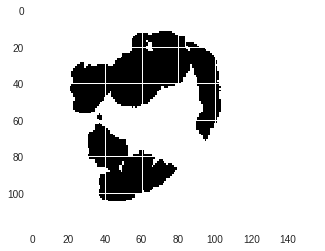

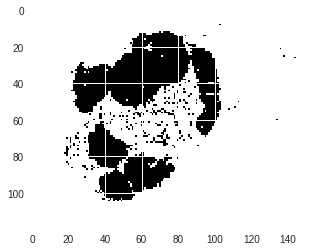

In [0]:
test_plt_lbls = test_lbls.reshape((nh,nw))
plt.figure()
plt.imshow(test_plt_lbls,cmap='gray_r')

test_plt_preds = test_preds.reshape((nh,nw))
plt.figure()
plt.imshow(test_plt_preds,cmap='gray_r')

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('accuracy: ', accuracy_score(test_lbls,test_preds))
print('f1 score: ', f1_score(test_lbls,test_preds))

accuracy:  0.9691698335385109
f1 score:  0.9153439153439152
